In [1]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [71]:
from datetime import datetime
from time import time
import os

PROJECT = "your-project-id-here"  # REPLACE WITH YOUR PROJECT ID
BUCKET = "your-bucket-id-here"  # REPLACE WITH YOUR BUCKET NAME
REGION = "us-central1"  # REPLACE WITH YOUR BUCKET REGION e.g. us-central1
MODEL_TYPE = "cnn"  # "linear", "cnn", "dnn_dropout", or "dnn"

# Do not change these
os.environ["PROJECT"] = PROJECT
os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION
os.environ["MODEL_TYPE"] = MODEL_TYPE
os.environ["TFVERSION"] = "2.6"  # Tensorflow  version
os.environ["IMAGE_URI"] = os.path.join("gcr.io", PROJECT, "mnist_models")

In [57]:
# %%writefile mnist_models/trainer/util.py
import tensorflow as tf


def scale(image, label):
    """Scales images from a 0-255 int range to a 0-1 float range"""
    image = tf.cast(image, tf.float32)
    image /= 255
    image = tf.expand_dims(image, -1)
    return image, label


def load_dataset(
        data, training=True, buffer_size=5000, batch_size=100, nclasses=10):
    """Loads MNIST dataset into a tf.data.Dataset"""
    (x_train, y_train), (x_test, y_test) = data
    x = x_train if training else x_test
    y = y_train if training else y_test
    # One-hot encode the classes
    y = tf.keras.utils.to_categorical(y, nclasses)
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(scale).batch(batch_size)
    if training:
        dataset = dataset.shuffle(buffer_size).repeat()
    return dataset

In [130]:
# %%writefile mnist_models/trainer/model.py
import os
import shutil

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import (
    Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Softmax)

# from . import util


# Image Variables
WIDTH = 28
HEIGHT = 28


def get_layers(
        model_type,
        nclasses=10,
        hidden_layer_1_neurons=600,
        hidden_layer_2_neurons=200,
        dropout_rate=0.25,
        num_filters_1=128,
        kernel_size_1=2,
        pooling_size_1=2,
        num_filters_2=32,
        kernel_size_2=3,
        pooling_size_2=2):
    """Constructs layers for a keras model based on a dict of model types."""
    model_layers = {
        'linear': [
            Flatten(),
            Dense(nclasses),
            Softmax()
        ],
        'dnn': [
            Flatten(),
            Dense(hidden_layer_1_neurons, activation='relu'),
            Dense(hidden_layer_2_neurons, activation='relu'),
            Dense(nclasses),
            Softmax()
        ],
        'dnn_dropout': [
            Flatten(),
            Dense(hidden_layer_1_neurons, activation='relu'),
            Dense(hidden_layer_2_neurons, activation='relu'),
            Dropout(dropout_rate),
            Dense(nclasses),
            Softmax()
        ],
        'cnn': [
            Conv2D(num_filters_1, kernel_size=kernel_size_1,
                   activation='relu', input_shape=(WIDTH, HEIGHT, 1)),
            MaxPooling2D(pooling_size_1),
            Conv2D(num_filters_2, kernel_size=kernel_size_2,
                   activation='relu'),
            MaxPooling2D(pooling_size_2),
            Flatten(),
            Dense(hidden_layer_1_neurons, activation='relu'),
            Dense(hidden_layer_2_neurons, activation='relu'),
            Dropout(dropout_rate),
            Dense(nclasses),
            Softmax()
        ]
    }
    return model_layers[model_type]


def build_model(layers, output_dir):
    """Compiles keras model for image classification."""
    model = Sequential(layers)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


def train_and_evaluate(model, num_epochs, steps_per_epoch, output_dir):
    """Compiles keras model and loads data into it for training."""
    mnist = tf.keras.datasets.mnist.load_data()
    train_data = load_dataset(mnist)
    validation_data = load_dataset(mnist, training=False)

    callbacks = []
    if output_dir:
        tensorboard_callback = TensorBoard(log_dir=output_dir)
        callbacks = [tensorboard_callback]

    history = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=num_epochs,
        steps_per_epoch=steps_per_epoch,
        verbose=2,
        callbacks=callbacks)

    if output_dir:
        export_path = os.path.join(output_dir, 'keras_export')
        model.save(export_path, save_format='tf')

    return history

In [131]:
# %%writefile mnist_models/trainer/test.py
import tensorflow as tf
import unittest

# from . import util
# from . import model

BENCHMARK_ERROR = .12
BENCHMARK_ACCURACY = 1 - BENCHMARK_ERROR
BATCH_SIZE = 100

# Add or remove types below ['linear', 'dnn', 'dnn_dropout', 'cnn'].
MODEL_TYPES = ['linear', 'dnn', 'dnn_dropout', 'cnn']
EPOCHS = 10
STEPS = 100


class TestInputFunction(unittest.TestCase):
    def create_shape_test(self, training):
        mnist = tf.keras.datasets.mnist.load_data()
        dataset = load_dataset(mnist, training, batch_size=BATCH_SIZE)
        data_iter = dataset.__iter__()
        (images, labels) = data_iter.get_next()
        expected_image_shape = (BATCH_SIZE, HEIGHT, WIDTH, 1)
        expected_label_ndim = 2
        self.assertEqual(images.shape, expected_image_shape)
        self.assertEqual(labels.numpy().ndim, expected_label_ndim)

    def test_train_dataset_batches_has_correct_shapes(self):
        self.create_shape_test(True)

    def test_eval_dataset_batches_has_correct_shapes(self):
        self.create_shape_test(False)


class TestModel(unittest.TestCase):
    @classmethod
    def setUpClass(cls):
        cls.histories = {}

        for model_type in MODEL_TYPES:
            print('\n*** Building model for', model_type, '***\n')
            layers = get_layers(model_type)
            image_model = build_model(layers, None)
            history = train_and_evaluate(image_model, EPOCHS, STEPS, None)
            cls.histories[model_type] = history.history

    def test_beats_benchmark(self):
        for model_type in MODEL_TYPES:
            with self.subTest(model_type=model_type):
                result = self.histories[model_type]
                self.assertGreater(result['accuracy'][-1], BENCHMARK_ACCURACY)
                self.assertGreater(result['val_accuracy'][-1], BENCHMARK_ACCURACY)

    def test_accuracy_is_improving(self):
        for model_type in MODEL_TYPES:
            with self.subTest(model_type=model_type):
                history = self.histories[model_type]
                accuracy = history['accuracy']
                val_accuracy = history['val_accuracy']
                self.assertLess(accuracy[0], accuracy[1])
                self.assertLess(accuracy[1], accuracy[-1])
                self.assertLess(val_accuracy[0], val_accuracy[1])
                self.assertLess(val_accuracy[1], val_accuracy[-1])

    def test_loss_is_decreasing(self):
        for model_type in MODEL_TYPES:
            with self.subTest(model_type=model_type):
                history = self.histories[model_type]
                loss = history['loss']
                val_loss = history['val_loss']
                self.assertGreater(loss[0], loss[1])
                self.assertGreater(loss[1], loss[-1])
                self.assertGreater(val_loss[0], val_loss[1])
                self.assertGreater(val_loss[1], val_loss[-1])


# if __name__ == '__main__':
#     unittest.main()


In [56]:
unittest.main(argv=['first-arg-is-ignored'], exit=False)

In [132]:
from datetime import datetime
import os

current_time = datetime.now().strftime("%y%m%d_%H%M%S")
model_type = 'cnn' # "linear", "cnn", "dnn_dropout", or "dnn"
job_dir = "mnist_models/models/{}_{}/".format(model_type, current_time)

In [133]:
def run():
    model_layers = get_layers(model_type)
    image_model = build_model(model_layers, job_dir)
    model_history = train_and_evaluate(image_model, EPOCHS, STEPS, job_dir)
    return image_model, model_history

start = time()
model, history = run()
end = time()
print(end-start)
print(history.history)

Epoch 1/10
100/100 - 13s - loss: 0.5659 - accuracy: 0.8204 - val_loss: 0.1464 - val_accuracy: 0.9596 - 13s/epoch - 129ms/step
Epoch 2/10
100/100 - 11s - loss: 0.1688 - accuracy: 0.9472 - val_loss: 0.0997 - val_accuracy: 0.9693 - 11s/epoch - 108ms/step
Epoch 3/10
100/100 - 11s - loss: 0.1286 - accuracy: 0.9594 - val_loss: 0.0800 - val_accuracy: 0.9744 - 11s/epoch - 109ms/step
Epoch 4/10
100/100 - 11s - loss: 0.0889 - accuracy: 0.9735 - val_loss: 0.0734 - val_accuracy: 0.9770 - 11s/epoch - 108ms/step
Epoch 5/10
100/100 - 11s - loss: 0.0903 - accuracy: 0.9723 - val_loss: 0.0636 - val_accuracy: 0.9796 - 11s/epoch - 107ms/step
Epoch 6/10
100/100 - 11s - loss: 0.0753 - accuracy: 0.9749 - val_loss: 0.0525 - val_accuracy: 0.9827 - 11s/epoch - 105ms/step
Epoch 7/10
100/100 - 11s - loss: 0.0567 - accuracy: 0.9835 - val_loss: 0.0522 - val_accuracy: 0.9827 - 11s/epoch - 113ms/step
Epoch 8/10
100/100 - 11s - loss: 0.0615 - accuracy: 0.9807 - val_loss: 0.0362 - val_accuracy: 0.9878 - 11s/epoch - 110

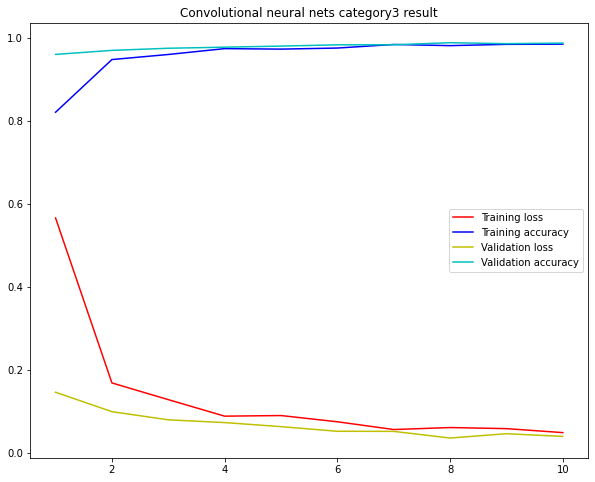

In [134]:
plt.figure(figsize= (10,8))
    
# plt.scatter(x, y, c='blue', label='Original data')
x = np.linspace(1, 10, num=10)
plt.plot(x, history.history['loss'], c='r', label = 'Training loss')
plt.plot(x, history.history['accuracy'], c='blue', label = 'Training accuracy')

plt.plot(x, history.history['val_loss'], c='y', label = 'Validation loss')
plt.plot(x, history.history['val_accuracy'], c='c', label = 'Validation accuracy')

plt.title('Convolutional neural nets category3 result')

plt.legend()
plt.savefig("cnn_cat3.png")
plt.show()
    

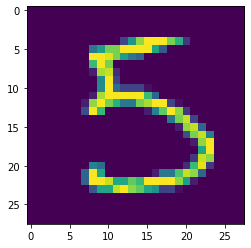

In [69]:
import json, codecs
import tensorflow as tf
import matplotlib.pyplot as plt
from mnist_models.trainer import util

HEIGHT = 28
WIDTH = 28
IMGNO = 15  #Change to select different image numbers

mnist = tf.keras.datasets.mnist.load_data()
(x_train, y_train), (x_test, y_test) = mnist
test_image = x_test[IMGNO]

jsondata = test_image.reshape(HEIGHT, WIDTH, 1).tolist()
json.dump(jsondata, codecs.open("test.json", "w", encoding = "utf-8"))
plt.imshow(test_image.reshape(HEIGHT, WIDTH));